## Машинное обучение, ВМК МГУ

## Практическое задание 4

### Общая информация

Дата выдачи: 22.10.2018

Дедлайн: 16.11.2018

### О задании

__Первая часть__ задания посвящена реализации различных слоёв нейронной сети.

__Вторая часть__ задания посвящена реализации алгоритма обратного распространения ошибки и обучение нейросети на задаче распознавания рукописных цифр MNIST.

__Третья часть__ задания посвящена реализации сверточного слоя и пулинга для улучшения решения задачи классификации из предыдущего пункта.


### Оценивание и штрафы
Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
import numpy as np

## Часть 1. Реализация слоёв графа вычислений

В этом задании мы реализуем граф вычислений для задачи распознавания изображений рукописных цифр на примере датасета [MNIST](http://yann.lecun.com/exdb/mnist/) — в частности, эта часть посвящена реализации всех требующихся для построения графа слоёв.

Указанная задача является задачей классификации на $K = 10$ классов, поэтому будем строить граф вычислений, выходной слой которого будет содержать 10 нейронов, $k$-ый из которых вычисляет оценку принадлежности объекта $k$-ому классу. В качестве функционала качества в данной задаче будем использовать **кросс-энтропию**:

$$Q(a, X) = -\frac{1}{l}\sum_{i=1}^l \sum_{k=1}^K [y_i = k] \log a_k(x_i),$$
где

$X = \{ (x_i, y_i)\}_{i=1}^l, \, y_i \in \{1, \dots, K\},$ — обучающая выборка,

$a(x) = (a_k(x))_{k=1}^K \in \mathbb{R}^K$ — прогноз графа вычислений для объекта $x$, состоящий из выходов $K$ нейронов выходного слоя (т.е. $a_k(x)$ — оценка принадлежности объекта $x$ классу $k$, построенная при помощи заданного графа вычислений).

Нейрнонные сети обучаются с использованием стохастических методов оптимизации, однако для ускорения обучения и большей стабильности за один проход параметры оптимизируются по батчу — набору из нескольких тренировочных примеров, также batch_size является дополнительной размерностью для входящих в слой тензоров.

Для начала определим класс Layer, реализующий тождественный слой, который будет являться базовым классом для всех последующих.

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """

    def __init__(self):
        """
        Here you can initialize layer parameters (if any) and auxiliary stuff.
        """

        raise NotImplementedError("Not implemented in interface")

    def forward(self, input):
        """
        Takes input data of shape [batch, ...], returns output data [batch, ...]
        """

        raise NotImplementedError("Not implemented in interface")

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input. Updates layer parameters and returns gradient for next layer
        Let x be layer weights, output – output of the layer on the given input and grad_output – gradient of layer with respect to output

        To compute loss gradients w.r.t parameters, you need to apply chain rule (backprop):
        (d loss / d x)  = (d loss / d output) * (d output / d x)
        Luckily, you already receive (d loss / d output) as grad_output, so you only need to multiply it by (d output / d x)
        If your layer has parameters (e.g. dense layer), you need to update them here using d loss / d x. The resulting update is a sum of updates in a batch.
        
        returns (d loss / d input) = (d loss / d output) * (d output / d input)
        """

        raise NotImplementedError("Not implemented in interface")

**Задание 1.**

Используя приведенные прототипы, реализуйте слой, применяющий функцию активации ReLU (Rectified Linear Unit) поэлементно к каждому из входов слоя:
$$\text{ReLU}(z) = \max (0, z)$$

In [3]:
class ReLU(Layer):
    def __init__(self):
        """
        ReLU layer simply applies elementwise rectified linear unit to all inputs
        This layer does not have any parameters.
        """
        pass
#         raise NotImplementedError("Implement me plz ;(")

    def forward(self, input):
        """
        Perform ReLU transformation
        input shape: [batch, input_units]
        output shape: [batch, input_units]
        """
        self.X = input
        return np.maximum(input, 0)
#         raise NotImplementedError("Implement me plz ;(")

    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. ReLU input
        """
        dydX = (self.X >=0).astype(float)
        return grad_output*dydX
#         raise NotImplementedError("Implement me plz ;(")

**Задание 2.**

Используя указанные прототипы, реализуйте полносвязный слой, выход которого вычисляется следующим образом (подробнее в презентации или, например, в следущей [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture11-dl.pdf)):

$$f(v; W, b)= Wv + b, $$

где
* v — выход предыдущего слоя (вектор размера num_inputs);
* W — матрица весов [num_inputs, num_outputs];
* b — столбец свободных членов (вектор размера num_outputs).

При создании полносвязного слоя веса $W, \; b$ необходимо проинициализировать веса с помощью GLOROT (какой именно вариант неважно). Про GLOROT можно прочитать здесь:
1. Простой пост: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
2. Статья с математикой: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

При каждом вызове backward() необходимо расчитать градиенты по выходу, используя chain-rule, и сделать один шаг градиентного спуска.

In [4]:
np.random.randn(2, 2)

array([[1.03207597, 0.13835394],
       [0.0327614 , 0.81183354]])

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = Wx + b

        W: matrix of shape [num_inputs, num_outputs]
        b: vector of shape [num_outputs]
        """

        self.learning_rate = learning_rate

        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * np.sqrt(2. / (input_units + output_units))
#         self.weights = np.random.uniform(-(6**0.5)/(input_units + output_units)**0.5, 
#                                          (6**0.5)/(input_units + output_units)**0.5,
#                                          (input_units, output_units))

        self.biases = np.zeros(output_units)
#         raise NotImplementedError("Implement me plz ;(")

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        Y = input.dot(self.weights)+self.biases
        return Y

#         raise NotImplementedError("Implement me plz ;(")

    def backward(self, input, grad_output):
        """
        input shape: [batch, input_units]
        grad_output: [batch, output units]

        Returns: grad_input, gradient of output w.r.t input
        """
        self.dLdW = input.T.dot(grad_output)
        self.dLdb = grad_output.sum(0)
        self.dLdx = grad_output.dot(self.weights.T)
        self.weights = self.weights - self.learning_rate * self.dLdW
        self.biases = self.biases - self.learning_rate * self.dLdb
        return self.dLdx
#         raise NotImplementedError("Implement me plz ;(")


**Задание 3.**

Как было сказано ранее, в качестве функционала качества в данной задаче мы будем использовать кросс-энтропию. Используя прототипы ниже, реализуйте вычисление данного функционала и его градиента по выходам графа вычислений.

Кросс-энтропия предполагает, что модель для каждого объекта выдает вероятности принадлежности к каждому из $K$ классов, т.е. что для одного объекта все $K$ вероятностей неотрицательны и суммируются в 1. В нашем же случае в построении графа участвуют только полносвязный и ReLU слои, а потому выходы графа не являются вероятностями — как правило, в этом случае прогноз $a(x)$ модели нормируется при помощи функции softmax следующим образом:

$$\text{softmax}(a_k(x)) = \frac{\exp(a_k(x))}{\sum_{k=1}^K \exp(a_k(x))}.$$

При реализации указанных функций предполагается, что переданные в качестве параметров оценки принадлежности объектов классам не являются нормированными (их еще называют логитами), но при вычислении указанных величин используйте указанное выше преобразование для приведения этих оценок к корректному виду.

In [6]:
def softmax_crossentropy_with_logits(logits, y_true):
    """
    Compute crossentropy from logits and ids of correct answers
    logits shape: [batch_size, num_classes]
    reference_answers: [batch_size]
    output is a number
    """
    X = logits
    c = X.max(1, keepdims = True)
    p = np.exp(X - c)
    p /= p.sum(1, keepdims=True)
    y = np.zeros((X.shape[0], X.shape[1]))
    y[np.arange(X.shape[0]), y_true] = 1
    return -(np.log(p)*y).sum(1).mean(0)



def grad_softmax_crossentropy_with_logits(logits, y_true):
    """
    Compute crossentropy gradient from logits and ids of correct answers
    Output should be divided by batch_size, so any layer update can be simply computed as sum of object updates.
    logits shape: [batch_size, num_classes]
    reference_answers: [batch_size]
    """
    X = logits
    c = X.max(1, keepdims = True)
    p = np.exp(X - c)
    p /= p.sum(1, keepdims=True)
    y = np.zeros((X.shape[0], X.shape[1]))
    y[np.arange(X.shape[0]), y_true] = 1
    return (p - y) / y.shape[0]


## Часть 2. Реализация и применение графа вычислений

В этой части мы научимся объединять слои в единый граф вычислений, а также использовать его для прямого прохода (вычисления прогнозов на объектах) и обратного прохода (обновление обучаемых параметров графа), после чего у нас появится возможность обучить граф. Для простоты реализации будем считать, что в нашем случае граф вычислений задается как список (python list) слоёв из числа реализованных ранее.

Ниже приведен код для скачивания датасета MNIST с официального сайта. Датасет делится на тренировочную и тестовую части. Тренировочная дополнительно разбивается на тренировочную и валидационную.

In [7]:
import sys
import os
import time
import gzip
from urllib.request import urlretrieve

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

Посмотрим на несколько объектов из этого датасета.

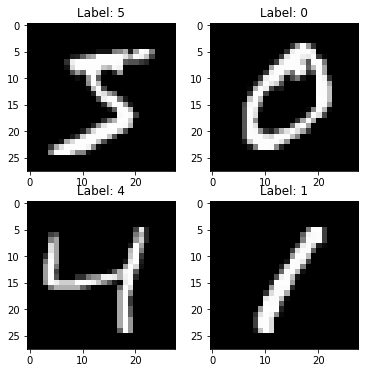

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]),cmap='gray');

**Задание 4.**

Используя прототип ниже, реализуйте прямой и обратный проход по графу вычислений и функцию для получения предсказаний метки класса.

In [9]:
class NeuralNetwork:
    def __init__(self, layers):
        """
        layers — list of Layer objects
        """
        
        self.layers = layers
        
    def forward(self, X):
        """
        Compute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        Make sure last activation corresponds to network logits.
        """
        
        activations = []
        input = X
        for i in range(len(self.layers)):
            input = self.layers[i].forward(input)
            activations.append(input)
            
            
            
#         raise NotImplementedError("Implement me plz ;(")
        assert len(activations) == len(self.layers)
        return activations

    def predict(self, X):
        """
        Use network to predict the most likely class for each sample.
        """
        layer_activations = self.forward(X)
        logits = layer_activations[-1]
        return np.argmax(logits, axis=1)
#         raise NotImplementedError("Implement me plz ;(")
    

    def backward(self, X, y):
        """
        Train your network on a given batch of X and y.
        You first need to run forward to get all layer activations.
        Then you can run layer.backward going from last to first layer.

        After you called backward for all layers, all Dense layers have already made one gradient step.
        """
        input = X
        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
#         print(layer_activations)
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        # propagate gradients through network layers using .backward
        # hint: start from last layer and move to earlier layers
        dLdy = loss_grad
        for i in list(range(len(self.layers)))[::-1]:
            dLdy = self.layers[i].backward(layer_inputs[i], dLdy)
#         raise NotImplementedError("Implement me plz ;(")

        return np.mean(loss)

In [10]:
layers = []
hidden_layers_size = 40
layers.append(Dense(X_train.shape[1], hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, 10))

model = NeuralNetwork(layers)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%. 

Ниже определена функции для итерации по батчам, принимающая на вход картинки, матки классов, а также размер батча и флаг отвечающий за перемешивание примеров.

In [11]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, seed=1234):
    assert len(inputs) == len(targets)
    
    indices = np.arange(len(inputs)).astype(np.int32)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        batch = indices[start_idx:start_idx + batchsize]
        
        yield inputs[batch], targets[batch]

Ниже приведены функции для обучения модели и отслеживания значения loss на тренироворочной части и на валидации.

In [12]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.98158
Val accuracy: 0.9628


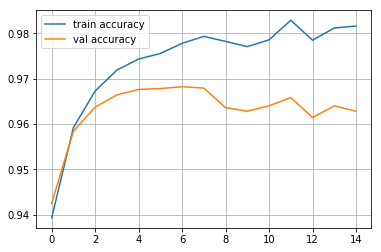

In [13]:
Loss = []
for epoch in range(15):
    LOSS = []
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
#         print("x_batch {}, y_batch {}".format(x_batch.shape, y_batch.shape))
        Loss.append(model.backward(x_batch, y_batch))
    
    train_log.append(np.mean(model.predict(X_train) == y_train))
    val_log.append(np.mean(model.predict(X_val) == y_val))
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

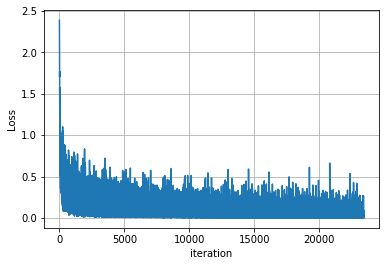

In [14]:
plt.plot(Loss)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

## Часть 3. Дополнительные слои

В этой части предлагается реализовать сверточный слой и слой maxpooling, а также разработать свою архитектуру графа вычислений с их использованием для повышения качества на валидационной выборке.

**Задание 5.** Реализуйте сверточный слой.

Рассмотрим один сверточный слой. Пусть на вход поступает изображение $X^l$ с $channels$ каналами, а сверточный слой $W$ имеет размер $k_1 \times k_2 \times channels$. Тогда применение слоя можно выразить следующим образом:

$$x_{ij}^{l} = \sum_{m=0}^{k_1 - 1} \sum_{n=0}^{k_2 - 1} \sum_{c=0}^{channels} w_{m, n, c}^{l} x_{i+m, j+n, c}^{l-1}$$

In [15]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = (H + 2 * padding - field_height) // stride + 1
    out_width = (W + 2 * padding - field_width) // stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                                 stride)
    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                               stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [16]:
class Conv2d(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, learning_rate=0.1, stride=1, padding=1):
        """
        A convolutional layer with out_channels kernels of kernel_size.

        in_channels — number of input channels
        out_channels — number of convolutional filters
        kernel_size — tuple of two numbers: k_1 and k_2

        Initialize required weights.
        """
        self.d_X  = in_channels

        self.n_filter, self.h_filter, self.w_filter = out_channels, kernel_size[0], kernel_size[1]
        self.stride, self.padding = stride, padding

        self.W = np.random.randn(out_channels,
            self.d_X, self.h_filter, self.w_filter) * np.sqrt(2. / (in_channels + out_channels))

        
        self.learning_rate = learning_rate

    def forward(self, input):
        """
        Perform convolutional transformation:

        input shape: [batch, in_channels, h, w]
        output shape: [batch, out_channels, h_out, w_out]
        """
        h_X, w_X = input.shape[2], input.shape[3]
        h_out = (h_X - self.h_filter + 2 * self.padding) / self.stride + 1
        w_out = (w_X - self.w_filter + 2 * self.padding) / self.stride + 1

        if not h_out.is_integer() or not w_out.is_integer():
            raise Exception("Invalid dimensions!")
        
        h_out, w_out = int(h_out), int(w_out)
        
        n_X = input.shape[0]

        X_col = im2col_indices(input, self.h_filter, self.w_filter, stride=self.stride, padding=self.padding)
        W_row = self.W.reshape(self.n_filter, -1)

        out = W_row @ X_col
        out = out.reshape(self.n_filter, h_out, w_out, n_X)
        out = out.transpose(3, 0, 1, 2)
        return out

    def backward(self, input, grad_output):
        
        h_X, w_X = input.shape[2], input.shape[3]
        h_out = (h_X - self.h_filter + 2 * self.padding) / self.stride + 1
        w_out = (w_X - self.w_filter + 2 * self.padding) / self.stride + 1
        if not h_out.is_integer() or not w_out.is_integer():
            raise Exception("Invalid dimensions!")
        h_out, w_out = int(h_out), int(w_out)
        n_X = input.shape[0]
        X_col = im2col_indices(input, self.h_filter, self.w_filter, stride=self.stride, padding=self.padding)
        
        dout_flat = grad_output.transpose(1, 2, 3, 0).reshape(self.n_filter, -1)
        dW = dout_flat @ X_col.T
        dW = dW.reshape(self.W.shape)
        W_flat = self.W.reshape(self.n_filter, -1)
        dX_col = W_flat.T @ dout_flat
        shape = (n_X, self.d_X, h_X, w_X)
        dX = col2im_indices(dX_col, shape, self.h_filter,
                            self.w_filter, self.padding, self.stride)
        self.W = self.W - self.learning_rate*dW
        
        return dX

**Задание 6.** Реализуйте слой макспулинга.

Ниже, на картинке, можно увидеть пример применения операции макспулинга с ядром размера 2x2 (слой применяется раздельно для каждого канала изображения).

<img width="50%" src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png">

## Используемый материал 
* https://medium.com/the-bioinformatics-press/only-numpy-understanding-back-propagation-for-max-pooling-layer-in-multi-layer-cnn-with-example-f7be891ee4b4
* https://becominghuman.ai/only-numpy-implementing-convolutional-neural-network-using-numpy-deriving-forward-feed-and-back-458a5250d6e4
* https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/
* https://deepnotes.io/convlayer
* https://github.com/parasdahal/deepnet/tree/master/deepnet

In [17]:
import skimage.measure

In [18]:
class Maxpool2d(Layer):
    def __init__(self, kernel_size):
        """
        A maxpooling layer with kernel of kernel_size.
        This layer donwsamples [kernel_size, kernel_size] to
        1 number which represents maximum.

        Stride description is identical to the convolution
        layer. But default value we use is kernel_size to
        reduce dim by kernel_size times.

        This layer does not have any learnable parameters.
        """
        self.stride = kernel_size[0]
        self.kernel_size = kernel_size[0]

    def forward(self, input):
        
        """
        Perform maxpooling transformation:

        input shape: [batch, in_channels, h, w]
        output shape: [batch, out_channels, h_out, w_out]
        """
        
        
        n = input.shape[0]
        d = input.shape[1]
        h, w = input.shape[2], input.shape[3]
        h_out = (h - self.kernel_size) // self.stride + 1
        w_out = (w - self.kernel_size) // self.stride + 1
        X_reshaped = input.reshape(n * d, 1, h, w)
        X_col = im2col_indices(X_reshaped, self.kernel_size, self.kernel_size, padding=0, stride=self.stride)
        max_idx = np.argmax(X_col, axis=0)
        out = X_col[max_idx, range(max_idx.size)]
        out = out.reshape(h_out, w_out, n, d)
        out = out.transpose(2, 3, 0, 1)
        return out

    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. Maxpool2d input
        """
#         print('Maxpool 2d backward')
        
        n = input.shape[0]
        d = input.shape[1]
        h, w = input.shape[2], input.shape[3]
        h_out = (h - self.kernel_size) // self.stride + 1
        w_out = (w - self.kernel_size) // self.stride + 1
        X_reshaped = input.reshape(n * d, 1, h, w)
        X_col = im2col_indices(X_reshaped, self.kernel_size, self.kernel_size, padding=0, stride=self.stride)
        max_idx = np.argmax(X_col, axis=0)
        
        dX_col = np.zeros_like(X_col)
        dout_flat = grad_output.transpose(2, 3, 0, 1).ravel()
        dX_col[max_idx, range(max_idx.size)] = dout_flat
        dX = col2im_indices(dX_col, (n * d, 1, h, w), self.kernel_size, self.kernel_size, padding=0, stride=self.stride)
        dX = dX.reshape(input.shape)
        return dX


**Задание 7.** Реализуйте слой для перевода n-мерного тензора в матрицу. Данный слой понадобится вам после использования сверточных слоев для перевода четырехмерного тензора в матрицу и дальнейшего использования результата в полносвязном слое для предсказания ненормированных вероятностей классов.

In [19]:
class Flatten(Layer):
    def __init__(self):
        """
        This layer does not have any parameters
        """
        pass

    def forward(self, input):
        
        
        """
        input shape: [batch_size, channels, feature_nums_h, feature_nums_w]
        output shape: [batch_size, channels * feature_nums_h * feature_nums_w]
        """
        X_shape = input.shape
        self.out_shape = (X_shape[0], -1)
        out = input.ravel().reshape(self.out_shape)
        self.out_shape = self.out_shape[1]
        return out

    def backward(self, input, grad_output):
        """
        Compute gradient of loss w.r.t. Flatten input
        """
        X_shape = input.shape
        out = grad_output.reshape(X_shape)
        return out

**Задание 8.** Подберите архитектуру сети, используя сверточные слои и слои макспулинга и превзойдите качество полносвязной сети.

### Использовал
* https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

In [22]:
layers = []
layers.append(Conv2d(in_channels=1, out_channels = 32,  kernel_size = (3,3)))
layers.append(ReLU())
layers.append(Conv2d(in_channels=32, out_channels = 32,  kernel_size = (3,3)))
layers.append(ReLU())
layers.append(Maxpool2d((2,2)))
layers.append(Conv2d(in_channels=32, out_channels = 64,  kernel_size = (3,3)))
layers.append(ReLU())
layers.append(Maxpool2d((2,2)))
layers.append(Flatten())
layers.append(Dense(3136, 512))
layers.append(ReLU())
layers.append(Dense(512, 10))
model = NeuralNetwork(layers)

In [23]:
from IPython.display import clear_output
import time
train_log = []
val_log = []

In [24]:
def time_format(seconds):
    seconds = int(seconds)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return hours, minutes, seconds

Summary time after start: 2 h 38 m 16 s
Epoch 4
Train accuracy: 0.9949383802816901
Val accuracy: 0.9863782051282052


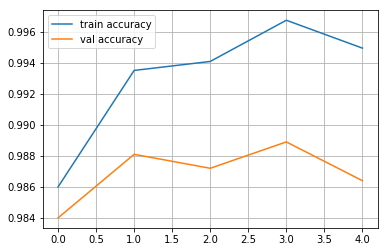

In [25]:
Loss = []
c = time.time()
for epoch in range(5):
    train_predicted = []
    var_predicted = []
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        Loss.append(model.backward(x_batch.reshape((-1, 1, 28, 28)), y_batch))
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=False):
        train_predicted.append(model.predict(x_batch.reshape((-1, 1, 28, 28))) == y_batch)
    for x_batch,y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=False):
        var_predicted.append(model.predict(x_batch.reshape((-1, 1, 28, 28))) == y_batch)
    train_log.append(np.mean(train_predicted))
    val_log.append(np.mean(var_predicted))
    
    clear_output()
    h, m, s = time_format(time.time() - c)
    print("Summary time after start: {} h {} m {} s".format(h, m, s))
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

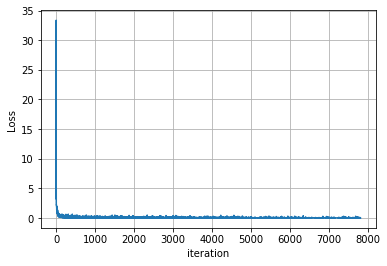

In [26]:
plt.plot(Loss)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [27]:
min(Loss)

1.72629084950901e-06

## Часть 4 (по желанию). Мемы

**Задание 9.** Какие мемы из 2k18 года вам запомнились больше всего?

**Примеры:**

https://yandex.ru/collections/user/web-ontology/liubimyi-nauchnik/

<img width="100%" src="https://memepedia.ru/wp-content/uploads/2017/08/%D0%BD%D0%B0-%D0%BC%D1%83%D0%B6%D0%B8%D0%BA-%D0%B8%D0%B7%D0%BE%D0%BB%D0%B5%D0%BD%D1%82%D1%83-3.jpg"/>

<img src="https://memepedia.ru/wp-content/uploads/2018/04/dyval37w0aitznj-1.jpg"/>